# Moirai + AdaPTS: Multivariate Blood Glucose Forecasting

**Model**: Salesforce/moirai-1.0-R-base (91M parameters)  
**Adapter**: AdaPTS betaVAE  
**Dataset**: Kaggle BrisT1D  
**Task**: Nocturnal blood glucose forecasting (6 hours)

Moirai is a time series foundation model with native multivariate support.
AdaPTS adds learned adapters for better feature extraction and uncertainty quantification.

In [1]:
import torch

# Project utilities
from src.data.diabetes_datasets.data_loader import get_loader
from src.data.models import ColumnNames

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


In [2]:
# Configuration
INTERVAL_MINS = 5
NOCTURNAL_HOURS = 6
TARGET_COL = ColumnNames.BG.value
CONTEXT_LENGTH = 512  # ~42 hours at 5-min intervals
FORECAST_HORIZON = 72  # 6 hours at 5-min intervals

# Features for multivariate
EXOG_FEATURES = [
    ColumnNames.IOB.value,
    ColumnNames.COB.value,
    # ColumnNames.STEPS.value,
    # ColumnNames.CALS.value,
]
ALL_FEATURES = [TARGET_COL] + EXOG_FEATURES

print(f"Target: {TARGET_COL}")
print(f"Features: {ALL_FEATURES}")
print(f"Predicting {FORECAST_HORIZON} steps ({NOCTURNAL_HOURS} hours)")

Target: bg_mM
Features: ['bg_mM', 'iob', 'cob']
Predicting 72 steps (6 hours)


In [3]:
# Load Kaggle BrisT1D dataset
loader = get_loader(
    data_source_name="kaggle_brisT1D", dataset_type="train", use_cached=True
)

train_data = loader.train_data
val_data = loader.validation_data

print(f"Training patients: {list(train_data.keys())}")
print(f"Validation patients: {list(val_data.keys())}")

# Show sample data
sample_patient = list(val_data.keys())[0]
sample_df = val_data[sample_patient]
print(f"\nSample patient {sample_patient}:")
print(f"  Shape: {sample_df.shape}")
print(f"  Columns: {sample_df.columns.tolist()}")
print(f"  Date range: {sample_df.index.min()} to {sample_df.index.max()}")

2026-01-10T11:02:52 - ============================================================
2026-01-10T11:02:52 - Beginning data loading process with the following parmeters:
2026-01-10T11:02:52 - 	Dataset: kaggle_brisT1D - train
2026-01-10T11:02:52 - 	Columns: None
2026-01-10T11:02:52 - 	Generic patient start date: 2024-01-01 00:00:00
2026-01-10T11:02:52 - 	Number of validation days: 20
2026-01-10T11:02:52 - 	In parallel with up to 3 workers.

2026-01-10T11:02:53 - Loaded full processed data from cache for 9 patients
2026-01-10T11:02:53 - Loaded existing train/validation split from cache for 9 patients


Training patients: ['p01', 'p03', 'p02', 'p04', 'p05', 'p06', 'p11', 'p12', 'p10']
Validation patients: ['p01', 'p03', 'p02', 'p04', 'p05', 'p06', 'p11', 'p12', 'p10']

Sample patient p01:
  Shape: (1921, 14)
  Columns: ['id', 'p_num', 'bg_mM', 'dose_units', 'food_g', 'hr_bpm', 'steps', 'cals', 'activity', 'msg_type', 'cob', 'carb_availability', 'insulin_availability', 'iob']
  Date range: 2024-03-11 06:55:00 to 2024-03-31 06:55:00


## Install Dependencies

Install AdaPTS and Moirai (uni2ts) packages. Run this cell once to install.

In [4]:
# Import Moirai + AdaPTS
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from adapts import adapts, adapters
from adapts.icl.moirai import MoiraiICLTrainer, load_moirai_model

print("Moirai and AdaPTS imports successful!")

/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Moirai and AdaPTS imports successful!


In [5]:
import numpy as np
import pandas as pd
from gluonts.dataset.common import ListDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error


def load_moirai_predictor(model_name: str, context_length: int, prediction_length: int):
    """Load a Moirai model and return a predictor."""
    print(f"Loading {model_name}...")
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(model_name),
        prediction_length=prediction_length,
        context_length=context_length,
        patch_size="auto",
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )
    predictor = model.create_predictor(batch_size=32)
    print("  Loaded successfully")
    return predictor


# Load baseline model: Moirai 1.0-R-base (91M params)
predictor_base = load_moirai_predictor(
    "Salesforce/moirai-1.0-R-base", CONTEXT_LENGTH, FORECAST_HORIZON
)

Loading Salesforce/moirai-1.0-R-base...
  Loaded successfully


In [6]:
# Build strict midnight-anchored episodes with full feature DataFrame
FEATURE_COLS = [TARGET_COL] + EXOG_FEATURES  # BG + exogenous


def build_midnight_feature_episodes(
    patient_df: pd.DataFrame,
    target_col: str,
    feature_cols: list[str],
    interval_mins: int,
    context_len: int,
    horizon: int,
):
    df = patient_df.sort_index()

    # Drop duplicate timestamps deterministically
    df = df[~df.index.duplicated(keep="last")]

    freq = f"{interval_mins}min"
    start = df.index.min().floor(freq)
    end = df.index.max().floor(freq)
    grid = pd.date_range(start, end, freq=freq)

    # Reindex all requested features to the fixed grid
    df = df.reindex(grid)

    dt = pd.Timedelta(minutes=interval_mins)
    earliest = start + context_len * dt
    latest = end - (horizon - 1) * dt

    first_midnight = earliest.normalize()
    if first_midnight < earliest:
        first_midnight += pd.Timedelta(days=1)

    last_midnight = latest.normalize()
    if last_midnight < first_midnight:
        return []

    episodes = []
    for anchor in pd.date_range(first_midnight, last_midnight, freq="D"):
        window_index = pd.date_range(
            anchor - context_len * dt,
            periods=context_len + horizon,
            freq=freq,
            inclusive="left",
        )

        window_df = df.reindex(window_index)[feature_cols]

        # Strict policy: no missing BG anywhere in window
        if window_df[target_col].isna().any():
            continue

        window_df = window_df.copy()
        window_df["datetime"] = window_df.index

        context_df = window_df.iloc[:context_len]
        target_bg = window_df.iloc[context_len:][target_col].to_numpy()
        target_df = window_df.iloc[context_len:]

        episodes.append(
            {
                "anchor": anchor,
                "context_df": context_df,
                "target_df": target_df,
                "target_bg": target_bg,
                "window_df": window_df,  # full context+horizon
            }
        )
    return episodes


# Build dictionary of episodes (train or val)
episodes_by_patient = {}
for pid, pdf in train_data.items():  # or val_data
    eps = build_midnight_feature_episodes(
        pdf,
        target_col=TARGET_COL,
        feature_cols=FEATURE_COLS,
        interval_mins=INTERVAL_MINS,
        context_len=CONTEXT_LENGTH,
        horizon=FORECAST_HORIZON,
    )
    if eps:
        episodes_by_patient[pid] = eps

print(f"Patients with clean episodes: {len(episodes_by_patient)}")
print({k: len(v) for k, v in episodes_by_patient.items()})

Patients with clean episodes: 6
{'p03': 55, 'p02': 54, 'p04': 36, 'p11': 43, 'p12': 44, 'p10': 46}


In [7]:
for pid, episodes in episodes_by_patient.items():
    for i, ep in enumerate(episodes):
        ctx_len = len(ep["context_df"])
        tgt_len = len(ep["target_bg"])
        if ctx_len != CONTEXT_LENGTH or tgt_len != FORECAST_HORIZON:
            print(f"ERROR: {pid} ep {i}: ctx={ctx_len}, tgt={tgt_len}")
    print(f"{pid}: {len(episodes)} episodes, all shapes correct")

p03: 55 episodes, all shapes correct
p02: 54 episodes, all shapes correct
p04: 36 episodes, all shapes correct
p11: 43 episodes, all shapes correct
p12: 44 episodes, all shapes correct
p10: 46 episodes, all shapes correct


Patient p03, anchor 2024-01-04 00:00:00


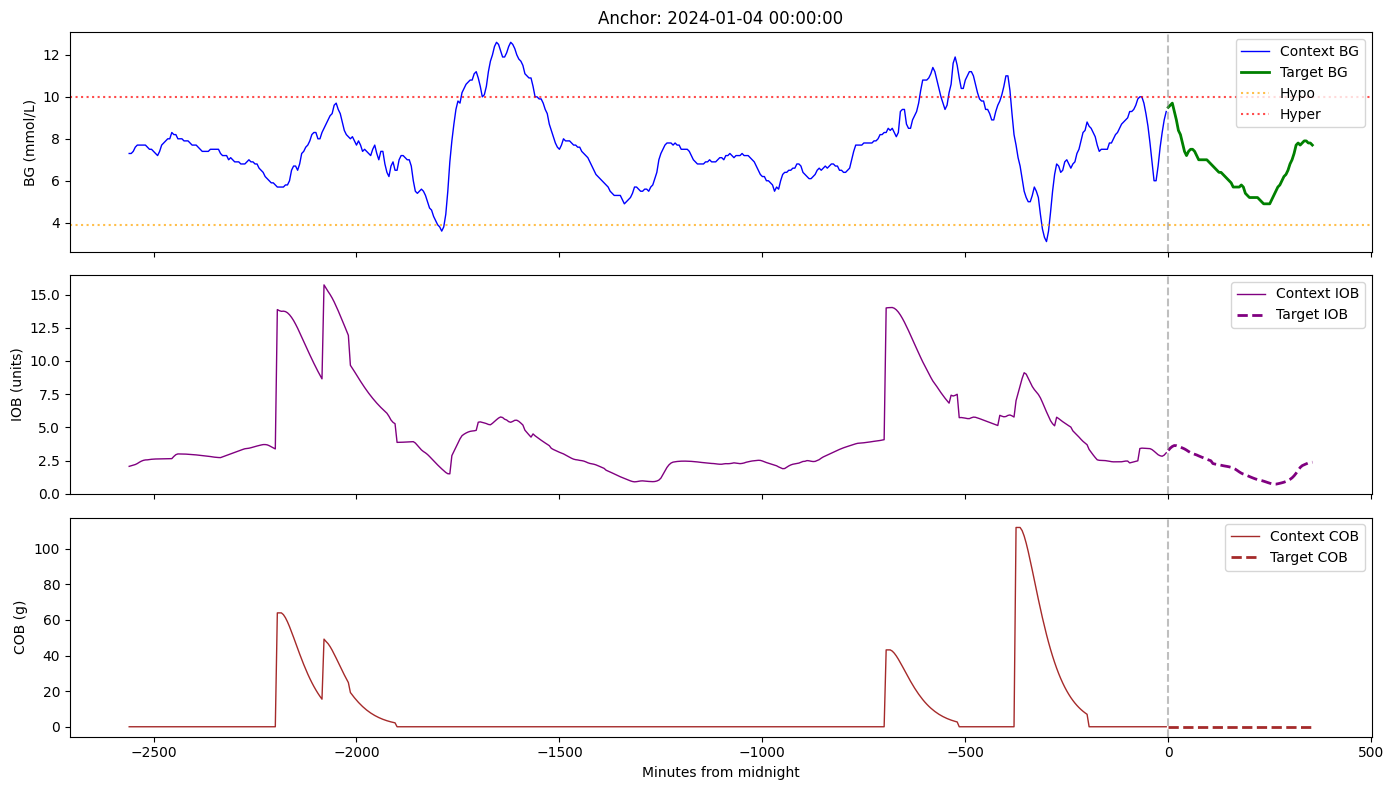

Patient p02, anchor 2024-01-06 00:00:00


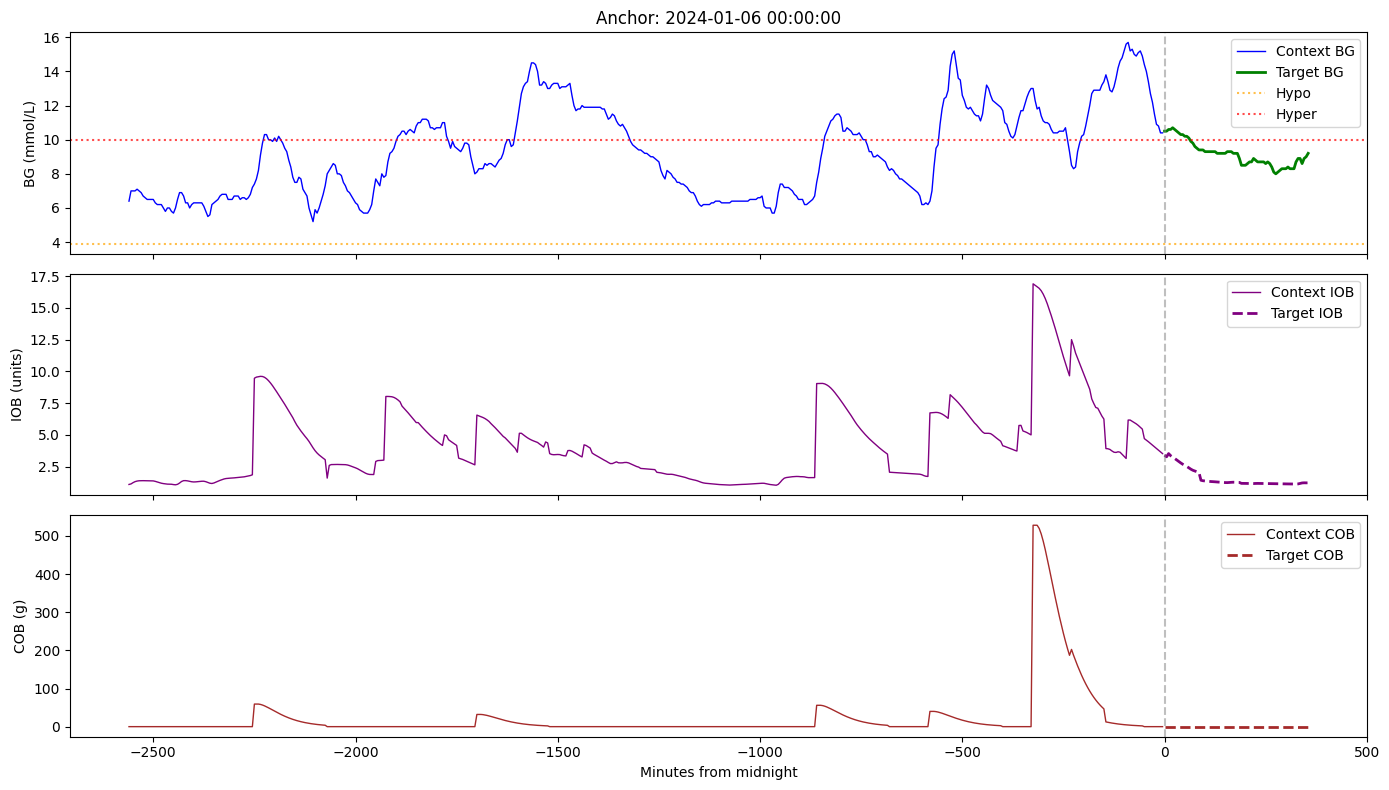

Patient p04, anchor 2024-01-04 00:00:00


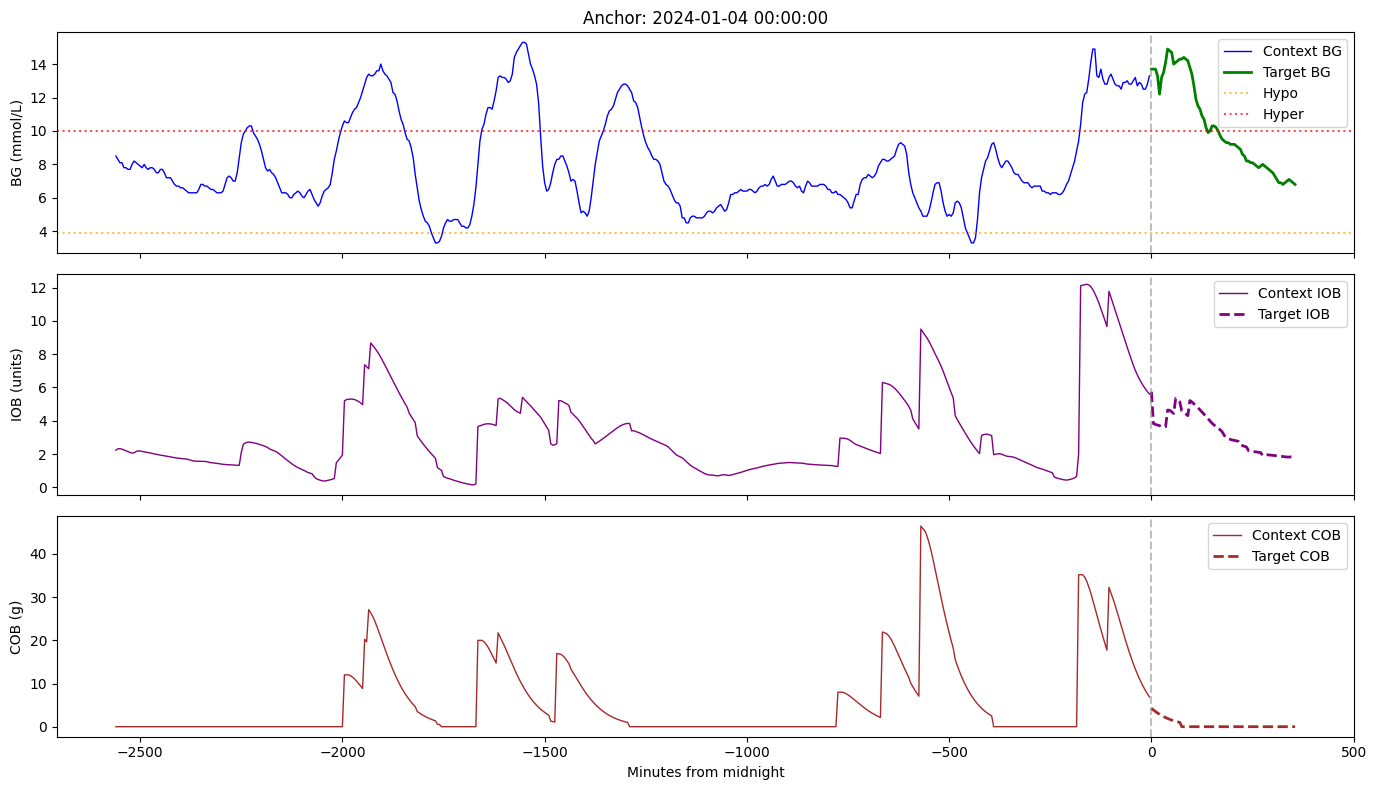

In [8]:
import matplotlib.pyplot as plt


def plot_episode(ep, interval_mins=5):
    """Plot a single episode showing context (BG, IOB, COB) and target."""
    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

    # Time axis
    ctx_len = len(ep["context_df"])
    tgt_len = len(ep["target_bg"])
    t_ctx = np.arange(-ctx_len, 0) * interval_mins
    t_tgt = np.arange(tgt_len) * interval_mins

    # Panel 1: BG (context + target)
    ax = axes[0]
    ax.plot(t_ctx, ep["context_df"][TARGET_COL].values, "b-", lw=1, label="Context BG")
    ax.plot(t_tgt, ep["target_bg"], "g-", lw=2, label="Target BG")
    ax.axhline(3.9, color="orange", ls=":", alpha=0.7, label="Hypo")
    ax.axhline(10.0, color="red", ls=":", alpha=0.7, label="Hyper")
    ax.axvline(0, color="gray", ls="--", alpha=0.5)
    ax.set_ylabel("BG (mmol/L)")
    ax.legend(loc="upper right")
    ax.set_title(f"Anchor: {ep['anchor']}")

    # Panel 2: IOB
    ax = axes[1]
    if "iob" in ep["context_df"].columns:
        ax.plot(
            t_ctx, ep["context_df"]["iob"].values, "purple", lw=1, label="Context IOB"
        )
        ax.plot(
            t_tgt,
            ep["target_df"]["iob"].values,
            "purple",
            lw=2,
            ls="--",
            label="Target IOB",
        )
        ax.axvline(0, color="gray", ls="--", alpha=0.5)
    ax.set_ylabel("IOB (units)")
    ax.legend(loc="upper right")

    # Panel 3: COB
    ax = axes[2]
    if "cob" in ep["context_df"].columns:
        ax.plot(
            t_ctx, ep["context_df"]["cob"].values, "brown", lw=1, label="Context COB"
        )
        ax.plot(
            t_tgt,
            ep["target_df"]["cob"].values,
            "brown",
            lw=2,
            ls="--",
            label="Target COB",
        )
        ax.axvline(0, color="gray", ls="--", alpha=0.5)
    ax.set_ylabel("COB (g)")
    ax.set_xlabel("Minutes from midnight")
    ax.legend(loc="upper right")

    plt.tight_layout()
    return fig


# Plot episodes from different patients
for pid in list(episodes_by_patient.keys())[:3]:
    ep = episodes_by_patient[pid][0]
    print(f"Patient {pid}, anchor {ep['anchor']}")
    plot_episode(ep)
    plt.show()

In [9]:
# Build validation episodes (strict BG policy)
val_episodes = {}
for pid, pdf in val_data.items():
    eps = build_midnight_feature_episodes(
        pdf,
        target_col=TARGET_COL,
        feature_cols=FEATURE_COLS,
        interval_mins=INTERVAL_MINS,
        context_len=CONTEXT_LENGTH,
        horizon=FORECAST_HORIZON,
    )
    if eps:
        val_episodes[pid] = eps

print(f"Validation patients with clean episodes: {len(val_episodes)}")
print({k: len(v) for k, v in val_episodes.items()})
print(f"Total validation episodes: {sum(len(v) for v in val_episodes.values())}")

Validation patients with clean episodes: 6
{'p03': 14, 'p02': 12, 'p04': 11, 'p11': 13, 'p12': 11, 'p10': 11}
Total validation episodes: 72


In [10]:
from tqdm import tqdm


def evaluate_moirai_on_episodes(
    predictor, val_episodes, target_col, interval_mins, model_name="model"
):
    """Evaluate a Moirai predictor on validation episodes."""
    all_results = []

    for pid, episodes in val_episodes.items():
        patient_rmse = []
        for ep in tqdm(episodes, desc=f"{model_name} - {pid}", leave=False):
            ctx = ep["context_df"][target_col].to_numpy()
            ctx_start = ep["context_df"].index[0]

            ds = ListDataset(
                [{"start": ctx_start, "target": ctx}], freq=f"{interval_mins}min"
            )
            forecast = list(predictor.predict(ds))[0]

            rmse = np.sqrt(mean_squared_error(ep["target_bg"], forecast.mean))
            mae = mean_absolute_error(ep["target_bg"], forecast.mean)

            all_results.append(
                {
                    "patient": pid,
                    "anchor": ep["anchor"],
                    "rmse": rmse,
                    "mae": mae,
                }
            )
            patient_rmse.append(rmse)

        print(f"  {pid}: RMSE={np.mean(patient_rmse):.3f}")

    results_df = pd.DataFrame(all_results)
    return results_df


# Evaluate baseline model
print("Evaluating Moirai 1.0-R-base (91M params)...")
results_base = evaluate_moirai_on_episodes(
    predictor_base, val_episodes, TARGET_COL, INTERVAL_MINS, "moirai-1.0-base"
)

print(f"\n{'='*50}")
print("Moirai 1.0-R-base Zero-Shot Results")
print(f"{'='*50}")
print(f"Episodes: {len(results_base)}")
print(
    f"RMSE: {results_base['rmse'].mean():.3f} +/- {results_base['rmse'].std():.3f} mmol/L"
)
print(
    f"MAE:  {results_base['mae'].mean():.3f} +/- {results_base['mae'].std():.3f} mmol/L"
)

Evaluating Moirai 1.0-R-base (91M params)...


  p03: RMSE=3.287


  p02: RMSE=3.155


  p04: RMSE=1.968


  p11: RMSE=2.229


  p12: RMSE=2.597


  p10: RMSE=1.549

Moirai 1.0-R-base Zero-Shot Results
Episodes: 72
RMSE: 2.502 +/- 1.374 mmol/L
MAE:  2.141 +/- 1.210 mmol/L


In [11]:
# Load and evaluate larger model: Moirai 1.1-R-large (311M params)
predictor_large = load_moirai_predictor(
    "Salesforce/moirai-1.1-R-large", CONTEXT_LENGTH, FORECAST_HORIZON
)

print("\nEvaluating Moirai 1.1-R-large (311M params)...")
results_large = evaluate_moirai_on_episodes(
    predictor_large, val_episodes, TARGET_COL, INTERVAL_MINS, "moirai-1.1-large"
)

print(f"\n{'='*50}")
print("Moirai 1.1-R-large Zero-Shot Results")
print(f"{'='*50}")
print(f"Episodes: {len(results_large)}")
print(
    f"RMSE: {results_large['rmse'].mean():.3f} +/- {results_large['rmse'].std():.3f} mmol/L"
)
print(
    f"MAE:  {results_large['mae'].mean():.3f} +/- {results_large['mae'].std():.3f} mmol/L"
)

Loading Salesforce/moirai-1.1-R-large...
  Loaded successfully

Evaluating Moirai 1.1-R-large (311M params)...


  p03: RMSE=3.680


  p02: RMSE=3.252


  p04: RMSE=2.332


  p11: RMSE=2.592


  p12: RMSE=2.775


  p10: RMSE=1.579

Moirai 1.1-R-large Zero-Shot Results
Episodes: 72
RMSE: 2.747 +/- 1.621 mmol/L
MAE:  2.338 +/- 1.429 mmol/L


In [12]:
# Model Comparison Summary
comparison = pd.DataFrame(
    {
        "Model": ["Moirai 1.0-R-base (91M)", "Moirai 1.1-R-large (311M)"],
        "RMSE": [results_base["rmse"].mean(), results_large["rmse"].mean()],
        "RMSE_std": [results_base["rmse"].std(), results_large["rmse"].std()],
        "MAE": [results_base["mae"].mean(), results_large["mae"].mean()],
        "MAE_std": [results_base["mae"].std(), results_large["mae"].std()],
    }
)

print("\n" + "=" * 60)
print("MODEL COMPARISON - Zero-Shot Nocturnal BG Forecasting")
print("=" * 60)
print(comparison.to_string(index=False))
print("\nNote: Lower is better. Units are mmol/L.")


MODEL COMPARISON - Zero-Shot Nocturnal BG Forecasting
                    Model     RMSE  RMSE_std      MAE  MAE_std
  Moirai 1.0-R-base (91M) 2.501619  1.374289 2.141207 1.210189
Moirai 1.1-R-large (311M) 2.747214  1.620857 2.337586 1.429383

Note: Lower is better. Units are mmol/L.


## AdaPTS: Adapting Moirai with Learned Adapters

AdaPTS learns an adapter layer that:
1. Projects multivariate input (BG, IOB, COB, etc.) to a latent space
2. Uses Moirai as a frozen foundation model for forecasting
3. Projects back to produce calibrated probabilistic forecasts

This allows leveraging domain-specific features (insulin, carbs) that Moirai wasn't trained on.

In [13]:
# Prepare episode data for AdaPTS
# AdaPTS expects: X shape (batch, n_features, context_len), y shape (batch, n_features, horizon)
# NOTE: y must be 3D with ALL features, not just BG!

# Use only features with actual data (steps/cals are mostly NaN)
ADAPTS_FEATURES = [TARGET_COL, "iob", "cob"]
print(f"AdaPTS features: {ADAPTS_FEATURES}")


def episodes_to_adapts_format(episodes_dict, feature_cols):
    """Convert episode dictionary to AdaPTS training format.

    Returns:
        X: (N, features, context_len) - context window for all features
        y: (N, features, horizon) - target window for all features (not just BG!)
    """
    X_list, y_list = [], []

    for pid, episodes in episodes_dict.items():
        for ep in episodes:
            # Context: (features, context_len)
            ctx = ep["context_df"][feature_cols].to_numpy().T

            # Target: (features, horizon) - ALL features, not just BG!
            tgt = ep["target_df"][feature_cols].to_numpy().T

            # Skip if any NaN in context or target
            if np.isnan(ctx).any() or np.isnan(tgt).any():
                continue

            X_list.append(ctx)
            y_list.append(tgt)

    return np.stack(X_list).astype(np.float32), np.stack(y_list).astype(np.float32)


# Convert training and validation episodes
X_train, y_train = episodes_to_adapts_format(episodes_by_patient, ADAPTS_FEATURES)
X_val, y_val = episodes_to_adapts_format(val_episodes, ADAPTS_FEATURES)

print("\nTraining data:")
print(f"  X_train: {X_train.shape}  (samples, features, context_len)")
print(f"  y_train: {y_train.shape}  (samples, features, horizon)")
print("\nValidation data:")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")

# Store ground truth BG for evaluation (first feature)
y_val_bg = y_val[:, 0, :]  # (samples, horizon) - BG only
print(f"\nGround truth BG shape for evaluation: {y_val_bg.shape}")

AdaPTS features: ['bg_mM', 'iob', 'cob']

Training data:
  X_train: (278, 3, 512)  (samples, features, context_len)
  y_train: (278, 3, 72)  (samples, features, horizon)

Validation data:
  X_val: (72, 3, 512)
  y_val: (72, 3, 72)

Ground truth BG shape for evaluation: (72, 72)


In [14]:
# Create AdaPTS model with MultichannelProjector (VAE adapter)
N_COMPONENTS = 2  # Latent dimension for adapter

# Use CPU to avoid MPS device mismatch issues in AdaPTS
adapts_device = "cpu"

# Load Moirai model for AdaPTS
moirai_model = load_moirai_model(
    model_name="Salesforce/moirai-1.0-R-base",
    forecast_horizon=FORECAST_HORIZON,
    context_length=CONTEXT_LENGTH,
)

# Create ICL trainer (wraps Moirai for AdaPTS)
# NOTE: n_features should be N_COMPONENTS (latent dim after adapter), not input features!
iclearner = MoiraiICLTrainer(
    model=moirai_model,
    n_features=N_COMPONENTS,  # Latent dimension, not input features!
    forecast_horizon=FORECAST_HORIZON,
)

# Create MultichannelProjector adapter with VAE
# NOTE: Must use MultichannelProjector wrapper, not betaVAE directly
adapter = adapters.MultichannelProjector(
    num_channels=len(ADAPTS_FEATURES),
    new_num_channels=N_COMPONENTS,
    base_projector="VAE",  # Uses betaVAE internally
    device=adapts_device,
    context_length=CONTEXT_LENGTH,
    forecast_horizon=FORECAST_HORIZON,
)

# Create the full AdaPTS model
adapts_model = adapts.ADAPTS(
    adapter=adapter,
    iclearner=iclearner,
    n_features=len(ADAPTS_FEATURES),
    n_components=N_COMPONENTS,
)

print("AdaPTS model created:")
print(f"  Input features: {len(ADAPTS_FEATURES)} ({ADAPTS_FEATURES})")
print(f"  Latent components: {N_COMPONENTS}")
print(f"  Context length: {CONTEXT_LENGTH}")
print(f"  Forecast horizon: {FORECAST_HORIZON}")
print(f"  Device: {adapts_device}")
print(f"  Adapter: {type(adapter.base_projector_).__name__}")
print(f"  ICL n_features: {iclearner.n_features} (= N_COMPONENTS)")

AdaPTS model created:
  Input features: 3 (['bg_mM', 'iob', 'cob'])
  Latent components: 2
  Context length: 512
  Forecast horizon: 72
  Device: cpu
  Adapter: betaVAE
  ICL n_features: 2 (= N_COMPONENTS)


In [ ]:
# Train the adapter with supervised fine-tuning
# NOTE: Skip fit_adapter() - it runs 100 epochs of unsupervised VAE pretraining (~30s/epoch)
# adapter_supervised_fine_tuning() fits the scaler and trains the adapter end-to-end
import os

os.makedirs("logs", exist_ok=True)  # AdaPTS requires log_dir to exist

print("Training AdaPTS adapter (supervised fine-tuning)...")
print(f"  Training samples: {len(X_train)}")
print(f"  Validation samples: {len(X_val)}")
print(f"  Device: {adapts_device}")

adapts_model.adapter_supervised_fine_tuning(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    device=adapts_device,
    learning_rate=0.001,
    batch_size=32,
    n_epochs=100,
    max_patience=20,
    log_dir="logs/",
    verbose=1,
)

print("\nAdapter training complete!")

/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-p

Training AdaPTS adapter (supervised fine-tuning)...
  Training samples: 278
  Validation samples: 72
  Device: cpu


Training Epochs:  45%|████▌     | 45/100 [1:07:48<1:06:24, 72.44s/it]

In [ ]:
# Generate predictions with AdaPTS
# NOTE: predict_multi_step expects X with shape (batch, features, context_len + horizon)
# It slices X[:, :, :-horizon] as context and uses the last horizon steps for comparison
print("Generating AdaPTS predictions...")

# Concatenate context (X_val) and target (y_val) along time axis
X_full = np.concatenate([X_val, y_val], axis=-1)  # (batch, features, context+horizon)
print(f"X_full shape: {X_full.shape} (context + horizon)")

# predict_multi_step returns tuple: (mean, mode, lb, ub)
# Each has shape (batch, n_features, horizon)
mean_pred, mode_pred, lb_pred, ub_pred = adapts_model.predict_multi_step(
    X=X_full,
    prediction_horizon=FORECAST_HORIZON,
    n_samples=100,
)

# Extract BG predictions (first feature, index 0)
y_pred_adapts = mean_pred[:, 0, :]
print(f"mean_pred shape: {mean_pred.shape} (batch, features, horizon)")
print(f"BG predictions shape: {y_pred_adapts.shape}")
print(f"Ground truth BG shape: {y_val_bg.shape}")

# Compute metrics using y_val_bg (BG only ground truth)
adapts_rmse = np.sqrt(mean_squared_error(y_val_bg.flatten(), y_pred_adapts.flatten()))
adapts_mae = mean_absolute_error(y_val_bg.flatten(), y_pred_adapts.flatten())

print(f"\n{'='*50}")
print("AdaPTS Results (with adapter training)")
print(f"{'='*50}")
print(f"RMSE: {adapts_rmse:.3f} mmol/L")
print(f"MAE:  {adapts_mae:.3f} mmol/L")

# Compare with zero-shot baseline
print(f"\n{'='*50}")
print("Comparison: Zero-Shot vs AdaPTS")
print(f"{'='*50}")
print(f"Zero-shot RMSE: {results_base['rmse'].mean():.3f} mmol/L")
print(f"AdaPTS RMSE:    {adapts_rmse:.3f} mmol/L")
improvement = (
    (results_base["rmse"].mean() - adapts_rmse) / results_base["rmse"].mean() * 100
)
print(f"Improvement:    {improvement:+.1f}%")

Generating AdaPTS predictions...
X_full shape: (72, 3, 584) (context + horizon)


inference batch: 100%|██████████| 1/1 [00:06<00:00,  6.43s/it]

mean_pred shape: (72, 3, 72) (batch, features, horizon)
BG predictions shape: (72, 72)
Ground truth BG shape: (72, 72)

AdaPTS Results (with adapter training)
RMSE: 3.002 mmol/L
MAE:  2.369 mmol/L

Comparison: Zero-Shot vs AdaPTS
Zero-shot RMSE: 2.502 mmol/L
AdaPTS RMSE:    3.002 mmol/L
Improvement:    -20.0%



/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-

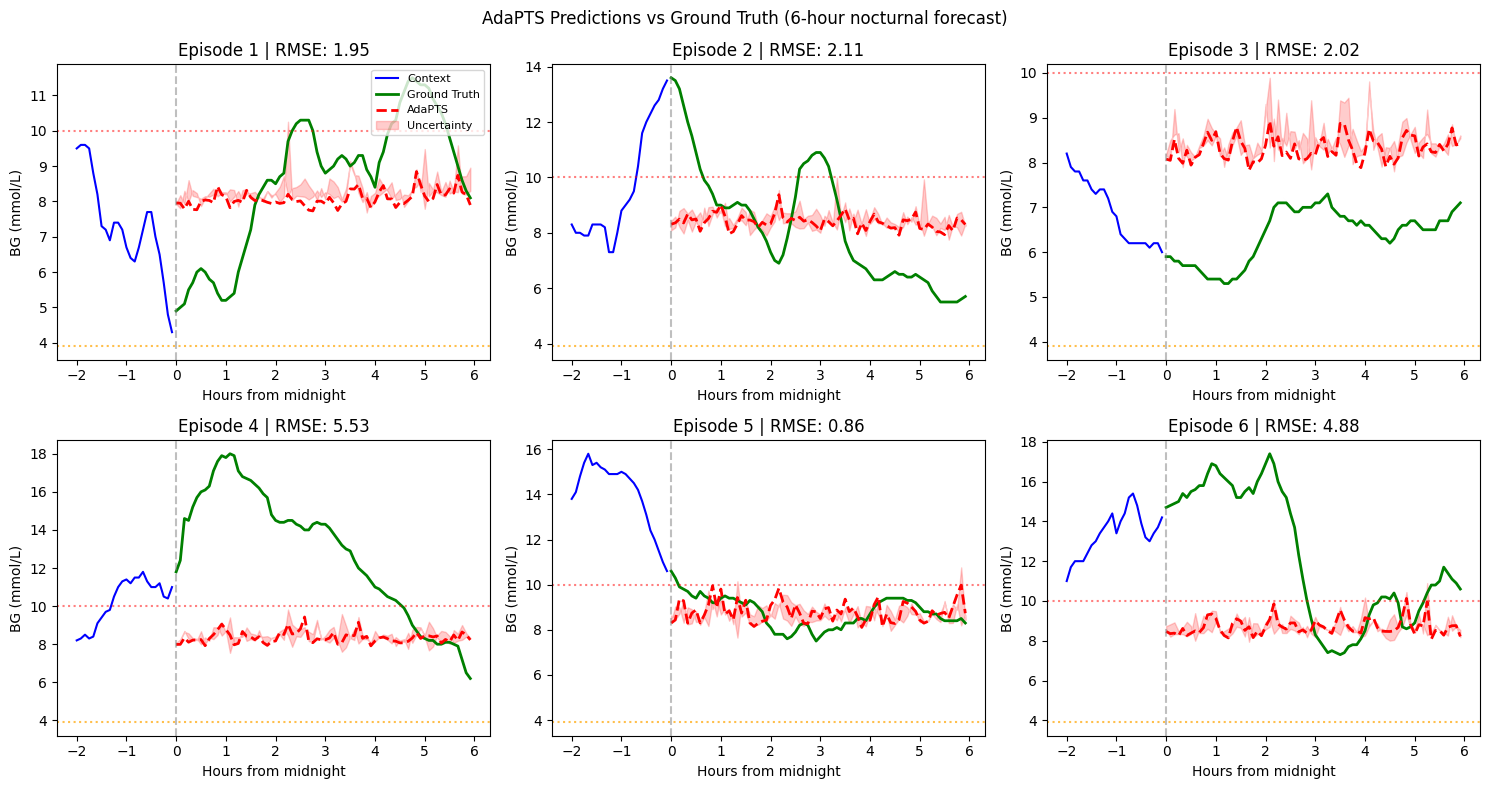


Per-episode RMSE statistics:
  Mean: 2.680
  Std:  1.353
  Min:  0.816
  Max:  7.392
  Median: 2.401


In [ ]:
# Visualize AdaPTS predictions vs ground truth
import matplotlib.pyplot as plt


def plot_adapts_forecasts(
    X_full, y_val_bg, mean_pred, lb_pred, ub_pred, n_plots=6, interval_mins=5
):
    """Plot AdaPTS forecasts vs ground truth for multiple episodes."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    # Time axis for forecast horizon
    t_forecast = np.arange(FORECAST_HORIZON) * interval_mins / 60  # hours

    # Get context BG for plotting (last 2 hours of context)
    context_steps = 24  # 2 hours at 5-min intervals
    t_context = (
        np.arange(-context_steps, 0) * interval_mins / 60
    )  # hours before midnight

    for i in range(min(n_plots, len(y_val_bg))):
        ax = axes[i]

        # Context BG (last 2 hours before midnight)
        ctx_bg = X_full[i, 0, -(FORECAST_HORIZON + context_steps) : -FORECAST_HORIZON]

        # Ground truth and predictions
        gt = y_val_bg[i]
        pred = mean_pred[i, 0, :]  # BG is first feature
        lb = lb_pred[i, 0, :]
        ub = ub_pred[i, 0, :]

        # Plot context
        ax.plot(t_context, ctx_bg, "b-", lw=1.5, label="Context")

        # Plot ground truth
        ax.plot(t_forecast, gt, "g-", lw=2, label="Ground Truth")

        # Plot AdaPTS prediction with uncertainty
        ax.plot(t_forecast, pred, "r--", lw=2, label="AdaPTS")
        ax.fill_between(t_forecast, lb, ub, color="red", alpha=0.2, label="Uncertainty")

        # Reference lines
        ax.axhline(3.9, color="orange", ls=":", alpha=0.7)
        ax.axhline(10.0, color="red", ls=":", alpha=0.5)
        ax.axvline(0, color="gray", ls="--", alpha=0.5)

        # RMSE for this episode
        rmse = np.sqrt(np.mean((gt - pred) ** 2))
        ax.set_title(f"Episode {i+1} | RMSE: {rmse:.2f}")
        ax.set_xlabel("Hours from midnight")
        ax.set_ylabel("BG (mmol/L)")

        if i == 0:
            ax.legend(loc="upper right", fontsize=8)

    plt.suptitle(
        "AdaPTS Predictions vs Ground Truth (6-hour nocturnal forecast)", fontsize=12
    )
    plt.tight_layout()
    return fig


# Plot first 6 episodes
fig = plot_adapts_forecasts(X_full, y_val_bg, mean_pred, lb_pred, ub_pred)
plt.show()

# Also compute per-episode RMSE distribution
episode_rmse = []
for i in range(len(y_val_bg)):
    rmse = np.sqrt(np.mean((y_val_bg[i] - mean_pred[i, 0, :]) ** 2))
    episode_rmse.append(rmse)

print("\nPer-episode RMSE statistics:")
print(f"  Mean: {np.mean(episode_rmse):.3f}")
print(f"  Std:  {np.std(episode_rmse):.3f}")
print(f"  Min:  {np.min(episode_rmse):.3f}")
print(f"  Max:  {np.max(episode_rmse):.3f}")
print(f"  Median: {np.median(episode_rmse):.3f}")